In [39]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
from helper_fns import yaml_load

nlpopts = { "print_time":False,      # Prints the time for evaluating objective, calculating gradients, etc
            "ipopt.print_level":0,   # Integer from 0 to 5, 5 printing the most information
            "ipopt.tol":1.0e-5,
            "ipopt.acceptable_constr_viol_tol":2.0e-04,
            "ipopt.warm_start_init_point":"yes",
            "ipopt.warm_start_bound_frac":1.0e-09,
            "ipopt.warm_start_bound_push":1.0e-09,
          }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from decision_vars import DecisionVarSet
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 3e4],
        'rest':[0, 0, 0.7]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
c = Contact('c/', par, [], attrs=attrs)
imp = ImpedanceController(pars={'imp_stiff':[300, 300, 300], 'imp_rest':[0, 0, 0.5]}, 
                          input_vars = ['imp_rest'],
                          attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [c], ctrl = imp, attrs = attrs, visc_fric = 100)

F:(p[3],R[3x3],dx[3],imp_rest[3],imp_stiff[3])->(F[3]) SXFunction
Building robot model from config/franka.urdf with TCP fr3_link8
  with subsys ['c/']
  Building controller imp_ctrl


In [43]:
from mpc import MPC
from helper_fns import mult_shoot_rollout

mpc = MPC(robots={'free':rob}, mpc_params={'H':7, 'dt':0.05}, nlpopts =nlpopts)
params = {'init_state': ca.DM.zeros(14), 
          'belief_free':1.0, 
          'imp_stiff':400*ca.DM.ones(3),}
res = mpc.solve(params)
traj = rob.get_ext_state_from_traj(res['xi'])

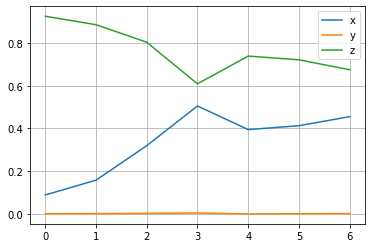

In [44]:
import matplotlib.pyplot as plt
import numpy as np

p = np.squeeze(np.array(traj['p']))
plt.plot(p, label=['x', 'y', 'z'])
plt.legend()

In [160]:
import time
N = 100
times = []

for _ in range(N):
    params['init_state'] += 0.05*np.random.randn(14) # perturb initial state
    tic = time.perf_counter()
    sol = mpc.solve(params)
    times.append(time.perf_counter()-tic)
    
print(f'Cold start time:  {times[0]} sec')
print(f'Cold start rate:  {1/times[0]} Hz')
print(f'Warm start rate: {1/np.mean(times[1:])} Hz')

Cold start time:  0.03526979999151081 sec
Cold start rate:  28.352868466526402 Hz
Warm start rate: 15.058741183146424 Hz


In [65]:
from robot import Robot
from contact import Contact
from impedance_controller import ImpedanceController
from decision_vars import DecisionVarSet
par = {'pos': [0, 0, 0.0],
       'stiff': [0, 0, 3e4],
        'rest':[0, 0, 0.7]}
attrs = yaml_load('config/attrs.yaml')
attrs = {k:attrs[k] for k in ['lb', 'ub']}
imp = ImpedanceController(pars={'imp_stiff':[300, 300, 300], 'imp_rest':[0, 0, 0.5]}, 
                          input_vars = ['imp_rest'],
                          attrs = attrs)
rob = Robot('config/franka.urdf', subsys = [], ctrl = imp, attrs = attrs, visc_fric = 100)
rob.build_step(0.1)
rob.build_rollout(6)
%timeit rob.rollout(np.zeros(14), np.zeros(3), np.zeros(3))

Building robot model from config/franka.urdf with TCP fr3_link8
  Building controller imp_ctrl
43.6 µs ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
